In [1]:
import numpy as np
%matplotlib inline
import Corrfunc
import glob

import utils
import plotter

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

import cmasher as cmr

In [11]:
def plot_cf_err(rs, cf_arrs, r_true, cf_true, labels, colors, err=False, xlim=None, errlim=None, cont=True, bases=None):
    
    if np.array(rs).ndim == 1:
        rs = [rs]
    if np.array(cf_arrs).ndim == 2:
        cf_arrs = np.array([cf_arrs])
    
    cfs_mean = []
    error_regions = []
    for cfs in cf_arrs:
        mean = np.mean(cfs, axis=0)
        cfs_mean.append(mean)
        std = np.std(cfs, axis=0)
        error_regions.append([mean-std, mean+std])
    
    plotter.plot_cf_cont(rs, cfs_mean, r_true, cf_true, labels, colors, error_regions=error_regions, 
                         err=err, xlim=xlim, errlim=errlim, cont=cont, bases=bases)

In [25]:
def plot_continuous(cat_tag, cf_tags, Nrealizations=100, colors=None, labels=None, err=True, errlim=None, 
                    cont=True, show_bases=True):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]
    xlim = [48.0, 144.0]
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    cf_arrs = []
    if show_bases:
        bases = []
    else:
        bases = None

    for i in range(len(cf_tags)):
        cf_tag = cf_tags[i]
        xis = []
        n_converged = 0

        for Nr in range(Nrealizations):
            
            if 'baoiter' in cf_tags[i]:
                fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
                for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                    #print(cf_fn)
                    r_avg, xi, amps, _, _ = np.load(cf_fn, allow_pickle=True)
                    #print("C:", amps[4])
                    n_converged +=1
                    break #should only be 1 match; but probs better way to do this
            else:
                cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
                r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)
            
            xis.append(xi)
        rs.append(r_avg)
        cf_arrs.append(xis)     

        if show_bases:
            if 'baoiter' in cf_tag:
                projfn = f'../tables/bases{cf_tag}{cat_tag}.dat'
            else:
                projfn = f'../tables/bases{cf_tag}.dat'
            base = np.loadtxt(projfn)
            bmax = max(np.array([base[bb,1:] for bb in range(base.shape[0]) if xlim[0]<base[bb,0]<xlim[1]]).flatten())
            base[:,1:] /= bmax
            bases.append(base)
                
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2

    plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, xlim=xlim, 
                errlim=errlim, cont=cont, bases=bases)

In [4]:
def plot_baoiter_converged(cat_tag, cf_tags, realizations=range(100), colors=None, labels=None, err=True, errlim=None):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]

    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    cf_arrs = []

    
    for i in range(len(cf_tags)):
        xis = []
        n_converged = 0
        for Nr in realizations:
            
            if 'baoiter' in cf_tags[i]:
                fn_pattern = f"cf{cf_tags[i]}_converged_*{cat_tag}_rlz{Nr}.npy"
                for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                    #print(cf_fn)
                    r_avg, xi, amps, _, _ = np.load(cf_fn, allow_pickle=True)
                    #print("C:", amps[4])
                    n_converged +=1
                    break #should only be 1 match; but probs better way to do this
            else:
                cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tags[i], cat_tag, Nr)
                r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)
                
            xis.append(xi)
        if 'baoiter' in cf_tags[i]:
            print(f"Found {n_converged} converged BAO cfs ({len(realizations)-n_converged} not converged)")
        rs.append(r_avg)
        cf_arrs.append(xis)     

    # true
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2

    xlim = [min(np.array(rs).flatten()), 148]
    plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, errlim=errlim, xlim=xlim)

In [8]:
# ctopmany = '#0077BB'
# ctopfew = '#33BBEE'
ctopmany = '#33BBEE'
ctopfew = '#0077BB'
cspline = '#EE3377'
cbao = '#228833'
ctheory = '#808080'

In [ ]:
# cmap = cmr.gem
# nc = 7
# colors = cmap(np.linspace(0, 1, nc))
# ctopmany = colors[4]
# ctopfew = colors[5]
# cspline = colors[3]
# cbao = colors[2]
#plt.scatter(np.arange(nc), np.ones(nc), s=250, c=colors)

(1, 1000)
rmse: True
plotting
0.0010186 100000.0


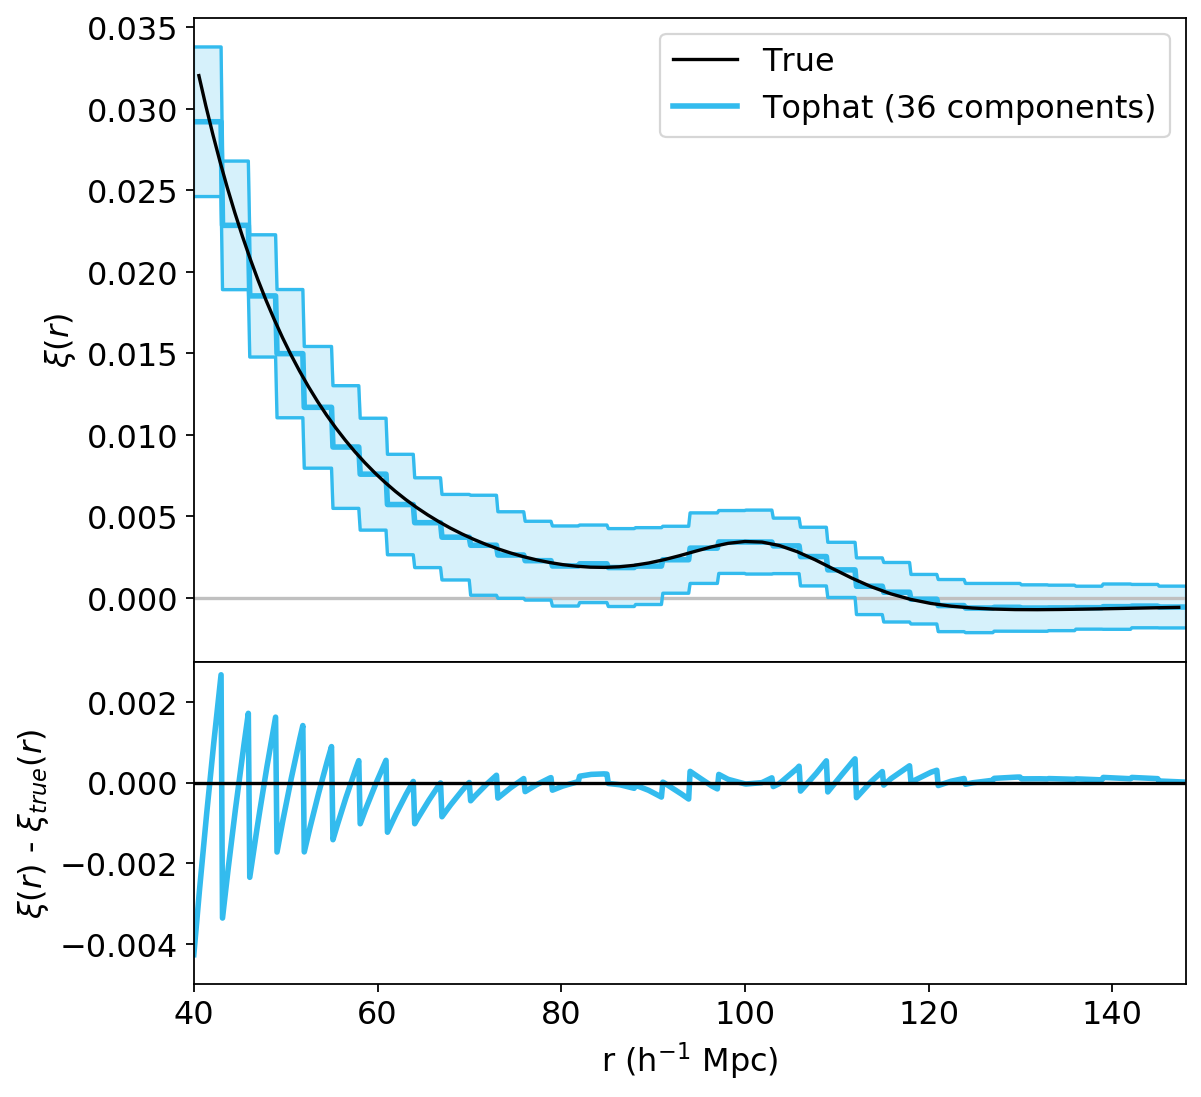

In [129]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3']
colors = [ctopmany]
labels = ['Tophat (36 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, errlim=[-0.005, 0.003])

(1, 52)
rmse: True
plotting
0.0010186 100000.0


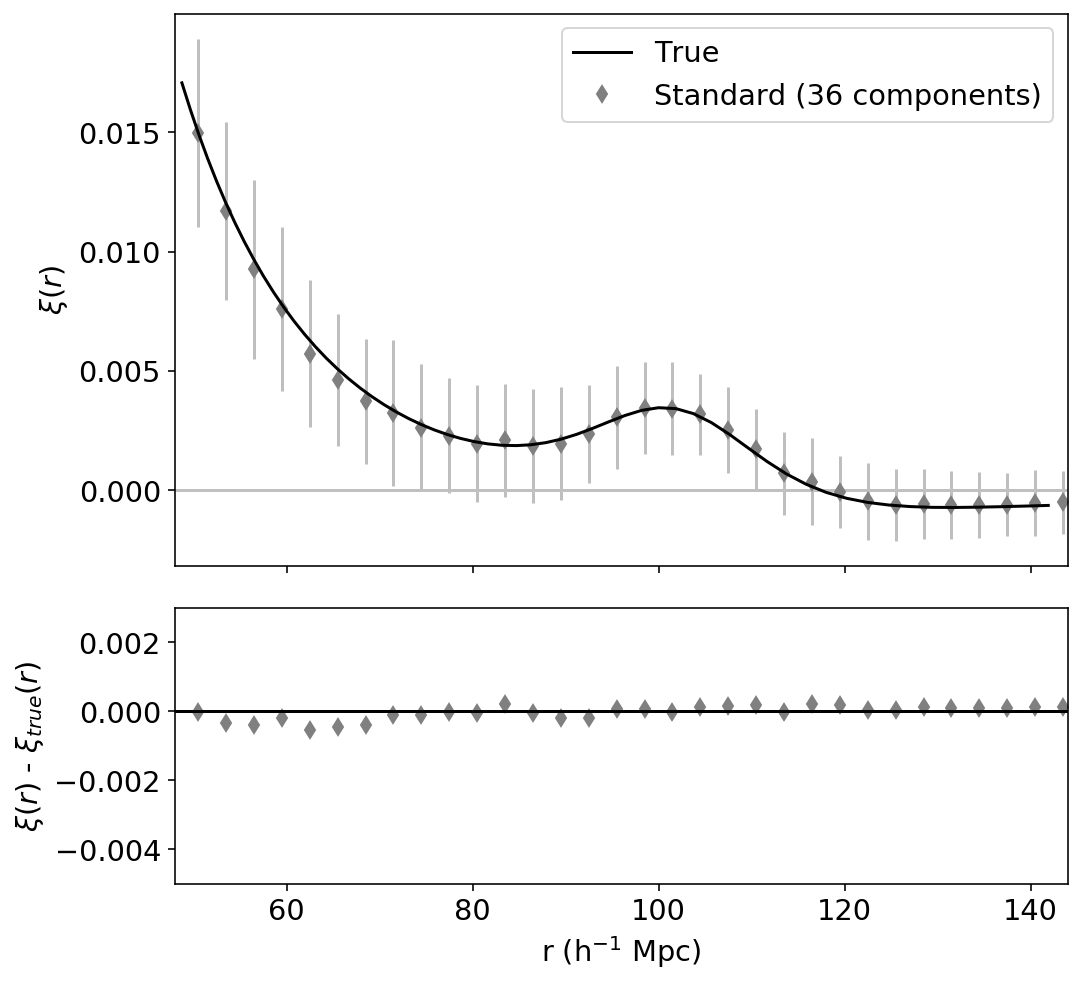

In [27]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_theory_bw3']
colors = [ctheory]
labels = ['Standard (36 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, cont=False, errlim=[-0.005, 0.003], show_bases=False)

In [28]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_theory_bw3', '_tophat_bw3']
colors = [ctheory, ctopmany]
labels = ['Standard (36 components)', 'Tophat (36 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, show_bases=False)#, errlim=[-0.006, 0.002])

ValueError: operands could not be broadcast together with shapes (52,) (1000,) 

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


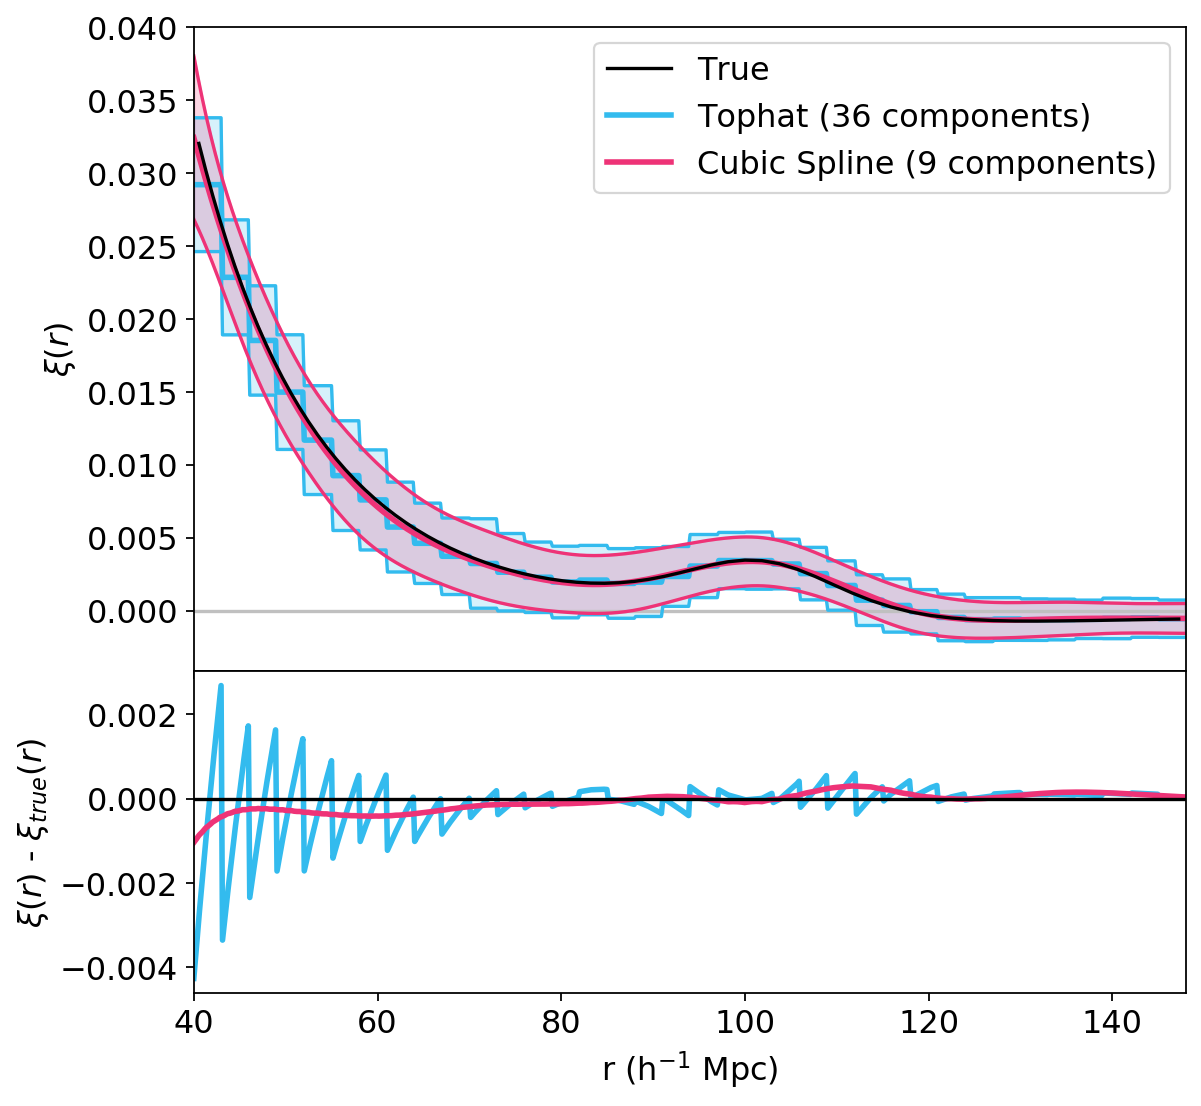

In [103]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (36 components)', 'Cubic Spline (9 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels)#, errlim=[-0.004, 0.004])

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


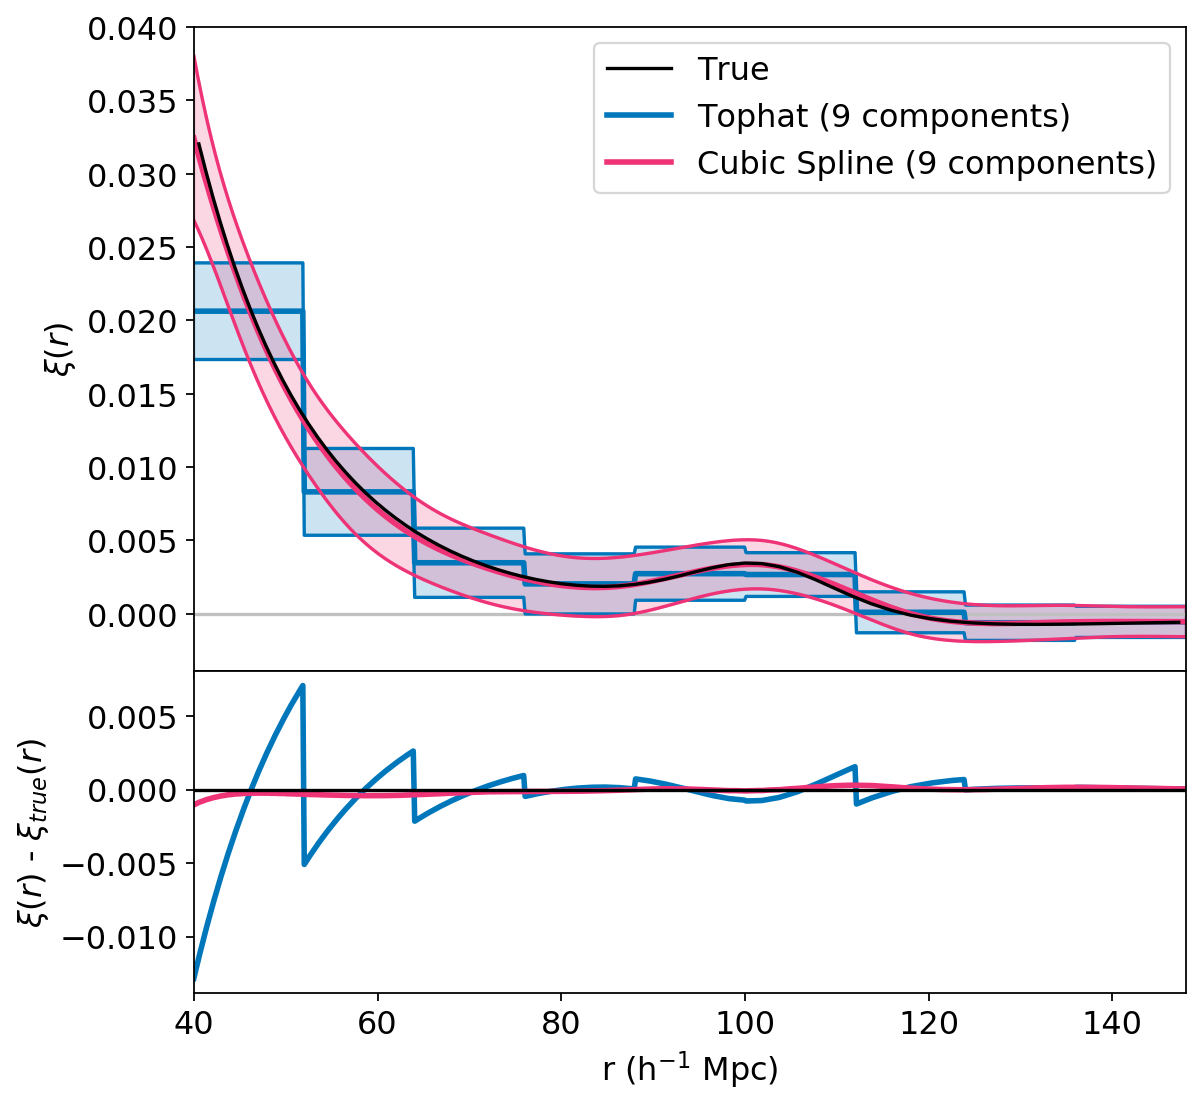

In [104]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw12', '_spline3_bw12']
colors = [ctopfew, cspline]
labels = ['Tophat (9 components)', 'Cubic Spline (9 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels)#, errlim=[-0.004, 0.004])

Found 88 converged BAO cfs (12 not converged)
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


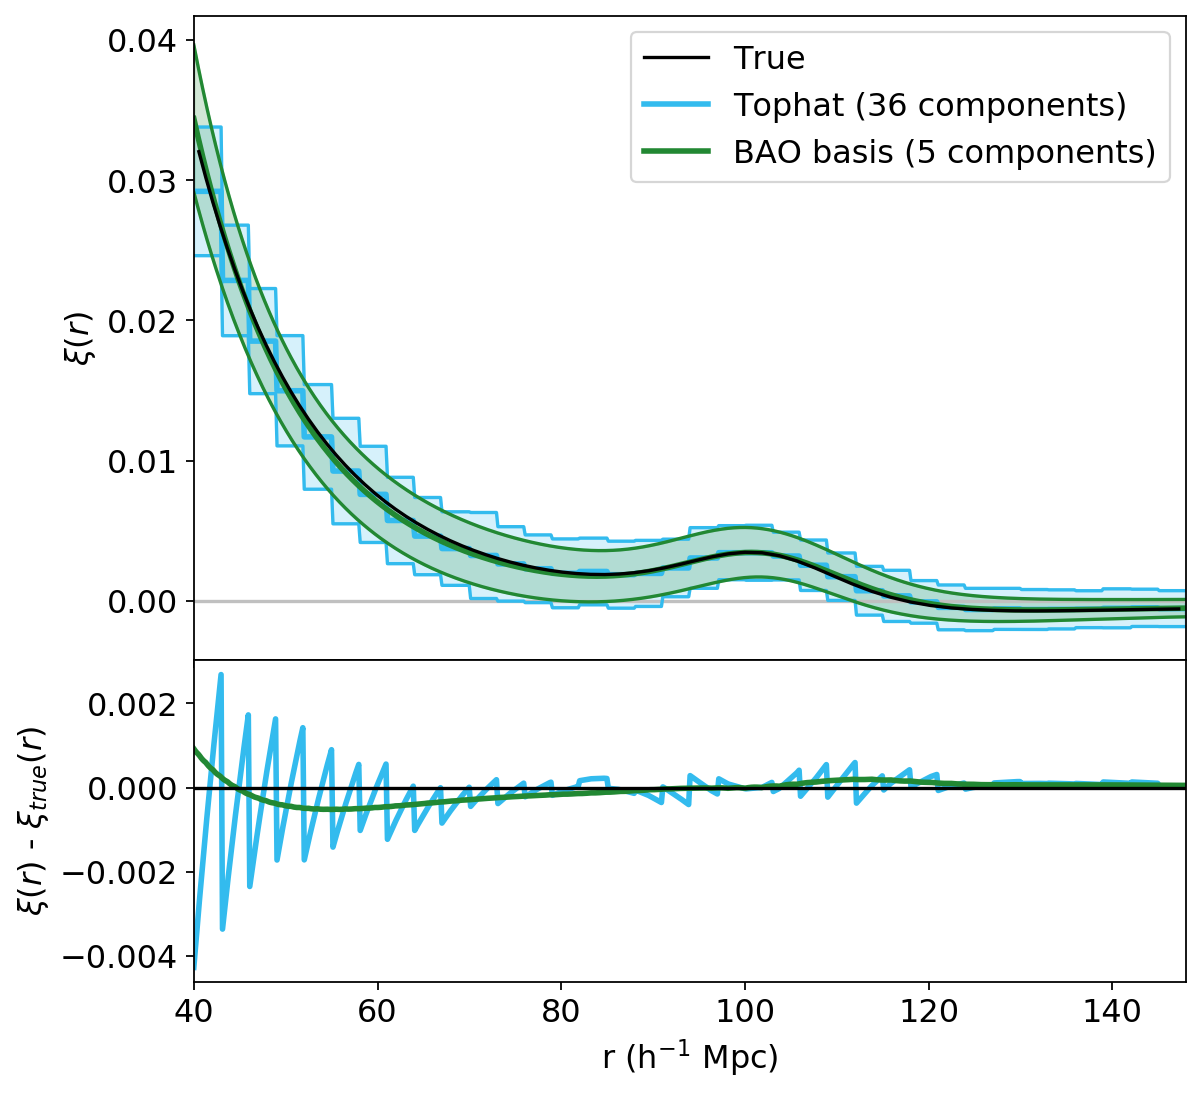

In [105]:
realizations=range(100)
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', f'_baoiter_cosmob17']
#colors = ['blue']*len(cf_tags)
#colors = ['blue', 'magenta']
colors = [ctopmany, cbao]
labels = ['Tophat (36 components)', 'BAO basis (5 components)']
plot_baoiter_converged(cat_tag, cf_tags, colors=colors, labels=labels, realizations=realizations)#, errlim=[-0.004, 0.004])

### Number density dependence

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


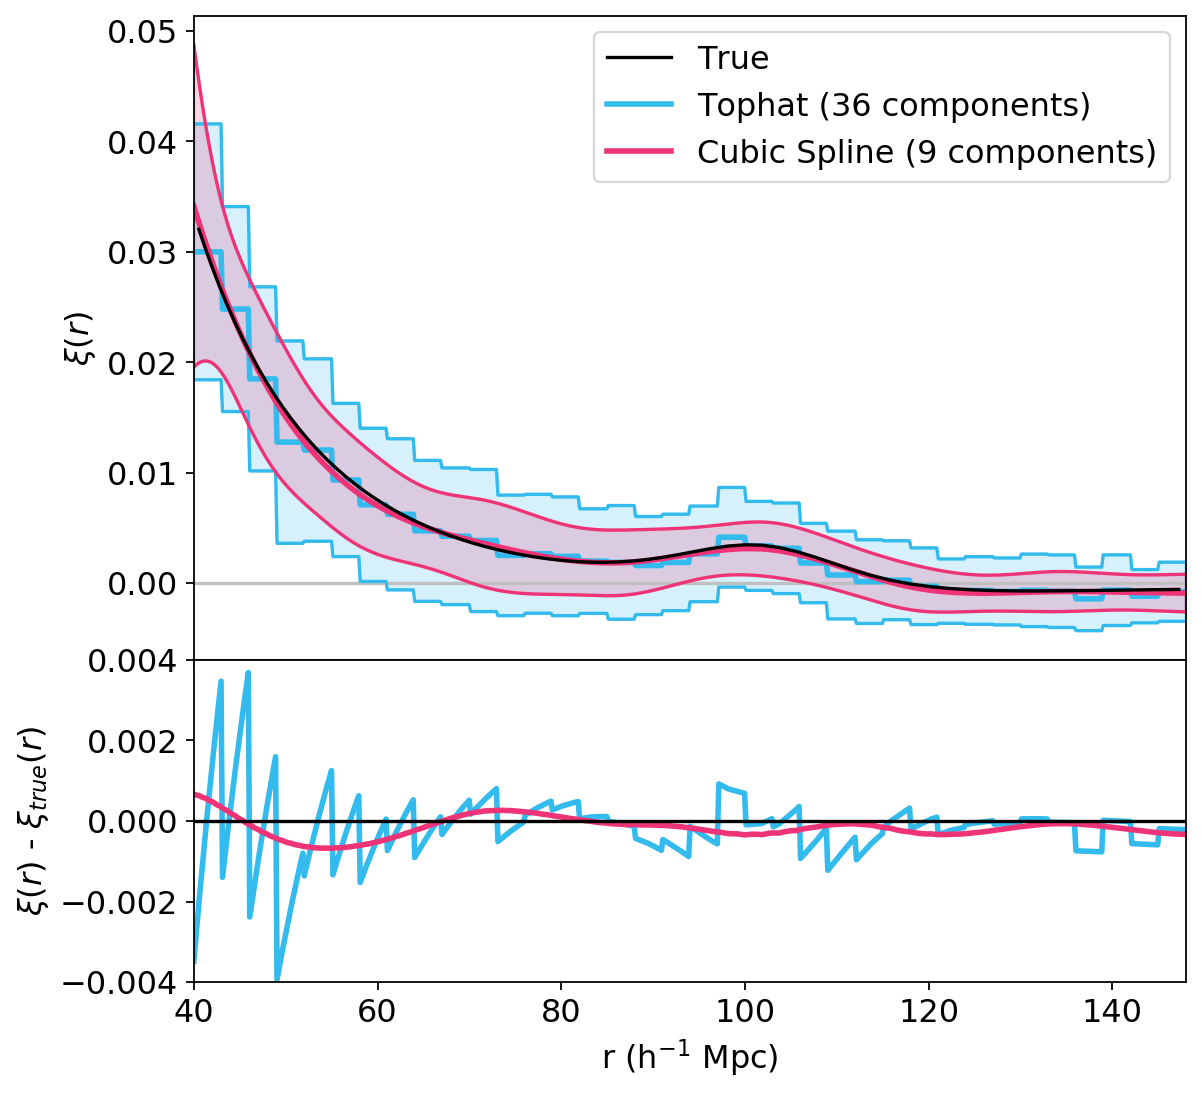

In [109]:
cat_tag = '_L750_n3e-5'
cf_tags = ['_tophat_bw3', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (36 components)', 'Cubic Spline (9 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, errlim=[-0.004, 0.004])

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


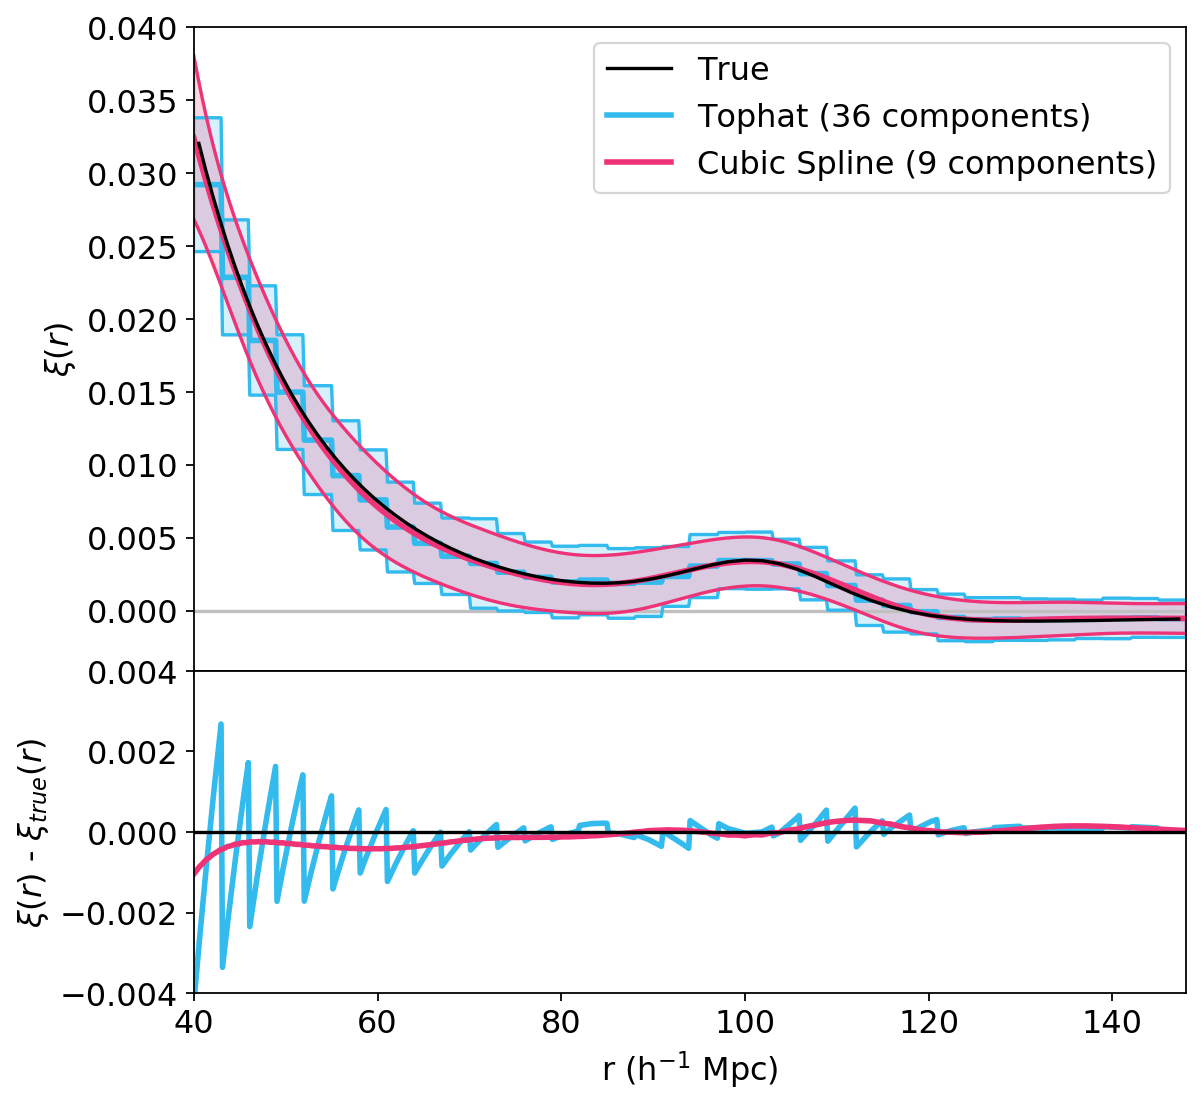

In [110]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (36 components)', 'Cubic Spline (9 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, errlim=[-0.004, 0.004])

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


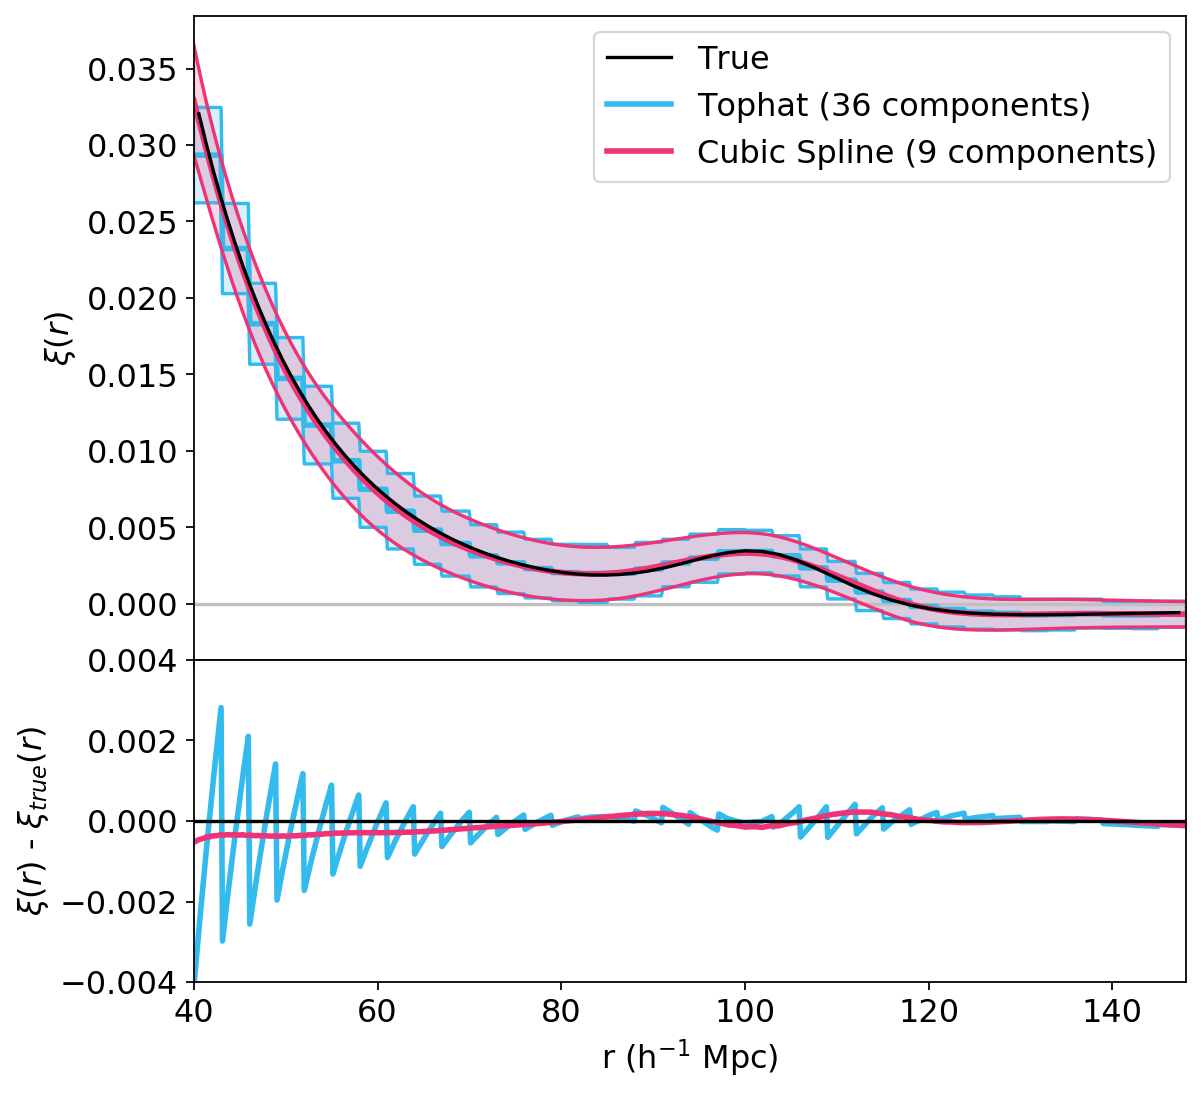

In [111]:
cat_tag = '_L750_n3e-4'
cf_tags = ['_tophat_bw3', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (36 components)', 'Cubic Spline (9 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, errlim=[-0.004, 0.004])

In [131]:
# TOD0: add bases to bottom of plots ?

(1000, 14)
(14,)
(1000,)
(1, 1000)
rmse: True
plotting
0.0010186 100000.0


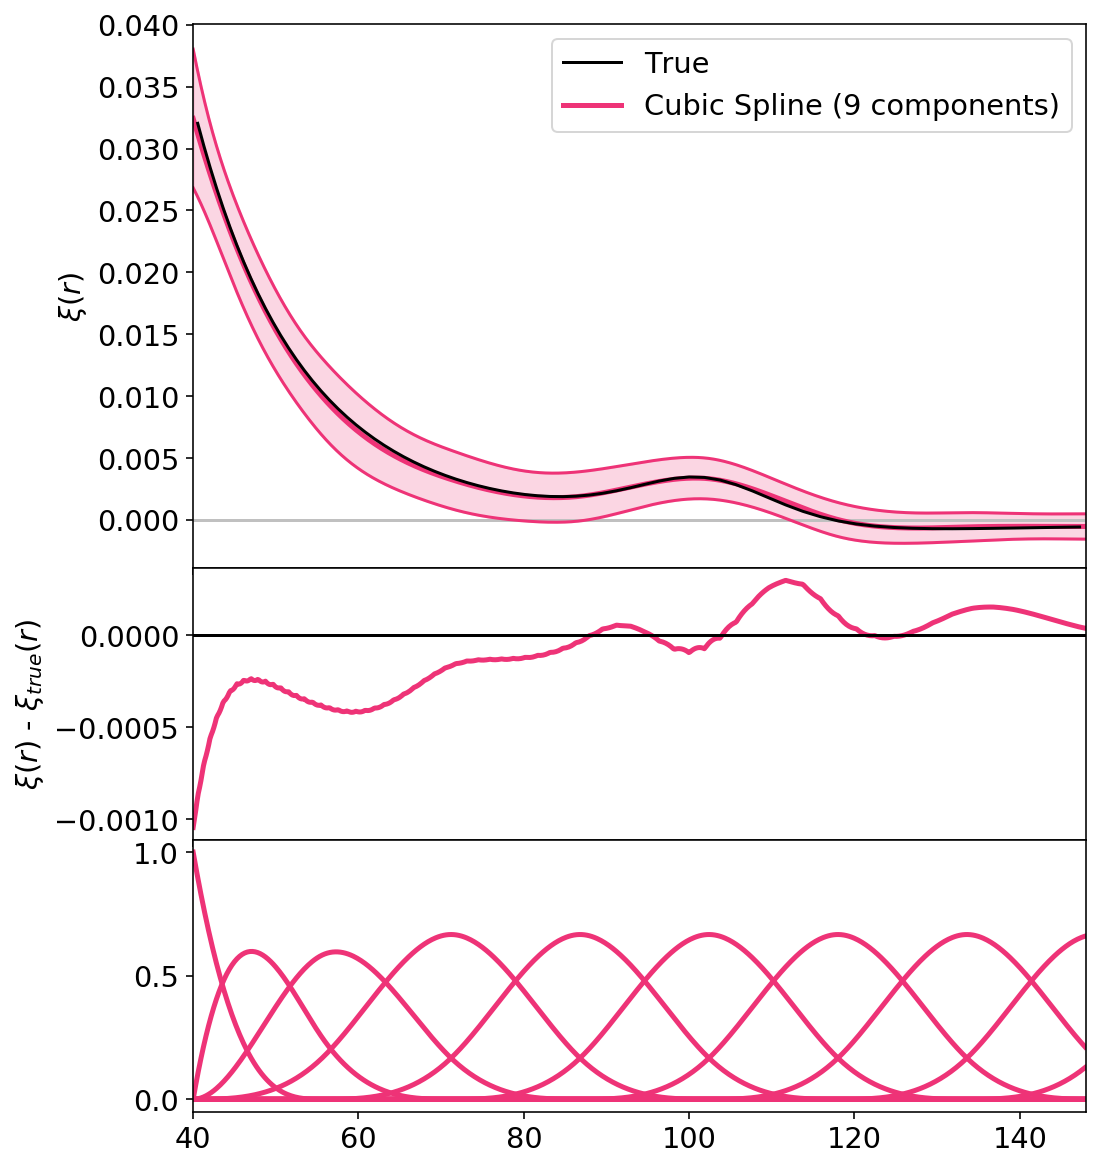

In [21]:

cat_tag = '_L750_n1e-4'
cf_tags = ['_spline3_bw12']

colors = [cspline]
labels = ['Cubic Spline (9 components)']
plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, show_bases=True)#, errlim=[-0.004, 0.004])